In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a CS_639 folder and put all the files under PS0 folder, then 'CS_639/PS0'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS_639/PS0'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'MadData Hackathon/' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['data', 'Untitled0.ipynb']


### Importing Libraries

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import warnings
warnings.filterwarnings('ignore')
from functools import lru_cache
from geopy.extra.rate_limiter import RateLimiter
import  time
from sklearn.cluster import KMeans

In [76]:
## Utility Methods
def plot_column_frequency(df, column_name, top_n=None):
    # Get the unique values in the column and their frequencies
    value_counts = df[column_name].value_counts()

    # Calculate the relative frequencies of each value
    value_freqs = value_counts / value_counts.sum()

    # Filter to the top n values, if specified
    if top_n is not None:
        value_counts = value_counts[:top_n]
        value_freqs = value_freqs[:top_n]

    # Create a bar plot of the relative frequencies
    plt.bar(value_freqs.index, value_freqs.values)

    # Add labels and title to the plot
    plt.xlabel(column_name)
    plt.ylabel('Relative Frequency')
    plt.title('Relative Frequency of ' + column_name + ' Values')

    # Rotate the x-axis labels and reduce font size
    plt.xticks(rotation=45, fontsize=8, ha='right')

    # Ensure that the x-axis starts from the first bar
    plt.xlim(xmin=-0.5)

    # Show the plot
    plt.show()

# Define a function to find the zip code for a given longitude and latitude
def find_zipcode(longitude, latitude):
    location = geolocator.reverse(f"{latitude}, {longitude}")
    address = location.raw['address']
    if 'postcode' in address:
        return address['postcode']
    else:
        return None

## Create dataframe

In [77]:
file_path = os.path.join(GOOGLE_DRIVE_PATH, 'data/Traffic_Crashes_-_Crashes.csv')
# Read in the CSV file as a pandas dataframe
df_main = pd.read_csv(file_path)


#### Breakdown Date + time

In [78]:
columns_relevant = ["CRASH_DATE", "POSTED_SPEED_LIMIT","TRAFFIC_CONTROL_DEVICE","NUM_UNITS","ROADWAY_SURFACE_COND","ALIGNMENT","DEVICE_CONDITION","DAMAGE","WEATHER_CONDITION","LIGHTING_CONDITION","PRIM_CONTRIBUTORY_CAUSE","INTERSECTION_RELATED_I","STREET_NO","STREET_NAME","STREET_DIRECTION","DOORING_I","TRAFFICWAY_TYPE","INJURIES_TOTAL","LATITUDE","LONGITUDE","LOCATION"]
df = df_main[columns_relevant]

# fix the date time
# Convert the 'CRASH_DATE' column to a datetime object
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], format='%m/%d/%Y %I:%M:%S %p')

# Extract the different components of the date and time
df['YEAR'] = df['CRASH_DATE'].dt.year
df['MONTH'] = df['CRASH_DATE'].dt.month
df['DAY'] = df['CRASH_DATE'].dt.day
df['HOUR'] = df['CRASH_DATE'].dt.hour
df['MINUTE'] = df['CRASH_DATE'].dt.minute
df['SECOND'] = df['CRASH_DATE'].dt.second
df['AM_PM'] = df['CRASH_DATE'].dt.strftime('%p')
#df

#### Add a zipcode column
This code is used to add a new column named 'zipcode' to a pandas DataFrame, based on the geographic location data in the DataFrame's 'LATITUDE' and 'LONGITUDE' columns. First, any rows with null values for latitude/longitude or 0 as an entry in those columns are removed. K-means clustering is applied to the remaining data, using the latitude and longitude values, to create clusters of locations with similar geographic locations. The resulting cluster means are then used to determine the zip code for each cluster, using a reverse geocoding API. The resulting zip code is mapped to each row in the original DataFrame based on which cluster that row belongs to, using the new 'cluster' column created by K-means clustering. Finally, a new column named 'zipcode' is added to the DataFrame, containing the corresponding zip code for each row.

In [80]:
# First remove all rows with null values for latitude/longitude
df = df.dropna(subset=["LATITUDE", "LONGITUDE"])

# Drop all rows where 'latitude' or 'longitude' columns have 0 as the entry
df = df.drop(df[(df['LATITUDE'] == 0.0) | (df['LONGITUDE'] == 0.0)].index)

# Extract the longitude and latitude columns from the DataFrame
X = df[['LONGITUDE', 'LATITUDE']]

# Apply K-means clustering with 88 clusters
kmeans = KMeans(n_clusters=88)
kmeans.fit(X)

# Add a new 'cluster' column to the DataFrame with the cluster labels
df['cluster'] = kmeans.labels_

# Group the DataFrame by 'cluster' column and find the mean longitude and latitude values for each cluster
cluster_means = df.groupby('cluster')[['LONGITUDE', 'LATITUDE']].mean()

# Convert the resulting DataFrame to a dictionary
cluster_dict = cluster_means.to_dict('index')

cluster_dict2 = {}
for key, value in cluster_dict.items():
    cluster_dict2[key] = tuple([cluster_dict[key]["LONGITUDE"],cluster_dict[key]["LATITUDE"]])

# Create a geolocator object for the Nominatim API
geolocator = Nominatim(user_agent="my-app")

cluster_dict3 = {}
for key, value in cluster_dict2.items():
    longitude, latitude = value
    zipcode = find_zipcode(longitude, latitude)
    cluster_dict3[key] = zipcode

# Create a new Series object by mapping the `clusterIndex` column to zipcodes
zipcodes_series = df['cluster'].map(cluster_dict3)

# Add the new Series to the DataFrame as a new column named `zipcode`
df['zipcode'] = zipcodes_series

### Save the dataset

In [87]:
file_path_to_save = os.path.join(GOOGLE_DRIVE_PATH, 'data/data_with_zipcode.csv')
df.to_csv(file_path_to_save, index=False)

In [90]:
file_path = os.path.join(GOOGLE_DRIVE_PATH, 'data/data_with_zipcode.csv')

# Read in the CSV file as a pandas dataframe
df = pd.read_csv(file_path)

In [91]:
df.columns

Index(['CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'NUM_UNITS', 'ROADWAY_SURFACE_COND', 'ALIGNMENT', 'DEVICE_CONDITION',
       'DAMAGE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'PRIM_CONTRIBUTORY_CAUSE', 'INTERSECTION_RELATED_I', 'STREET_NO',
       'STREET_NAME', 'STREET_DIRECTION', 'DOORING_I', 'TRAFFICWAY_TYPE',
       'INJURIES_TOTAL', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'YEAR', 'MONTH',
       'DAY', 'HOUR', 'MINUTE', 'SECOND', 'AM_PM', 'cluster', 'zipcode'],
      dtype='object')

## Exploratory Data Analysis

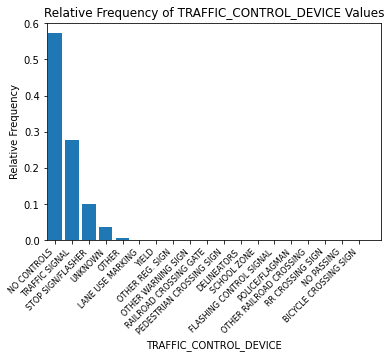

In [ ]:
plot_column_frequency(df, "TRAFFIC_CONTROL_DEVICE")

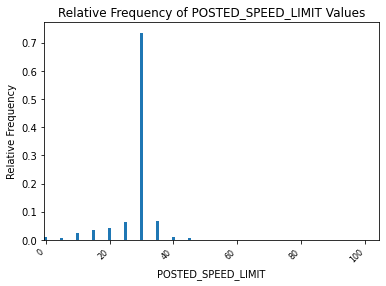

In [ ]:
plot_column_frequency(df, "POSTED_SPEED_LIMIT")

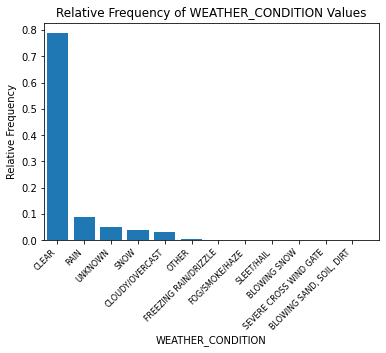

In [ ]:
plot_column_frequency(df, "WEATHER_CONDITION")

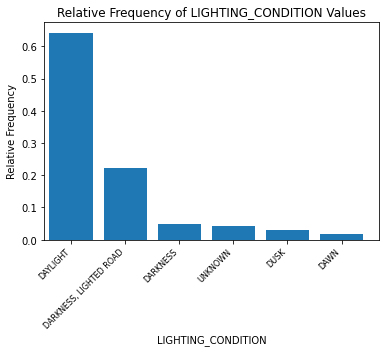

In [ ]:
plot_column_frequency(df, "LIGHTING_CONDITION")

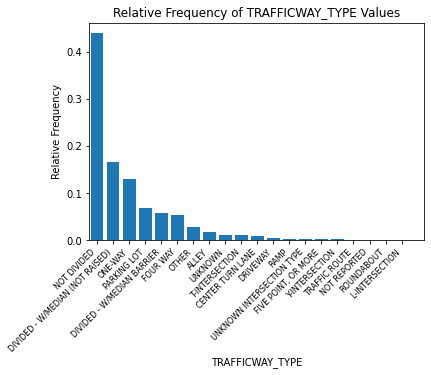

In [ ]:
plot_column_frequency(df, "TRAFFICWAY_TYPE")

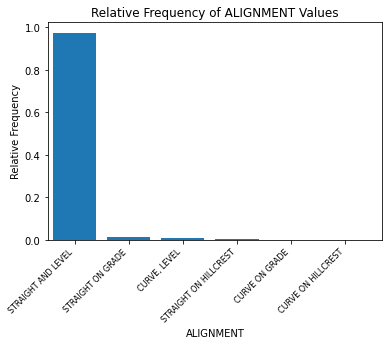

In [ ]:
plot_column_frequency(df, "ALIGNMENT")

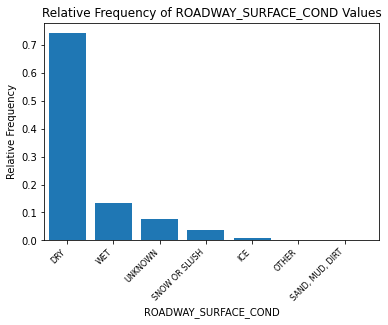

In [ ]:
plot_column_frequency(df, "ROADWAY_SURFACE_COND")

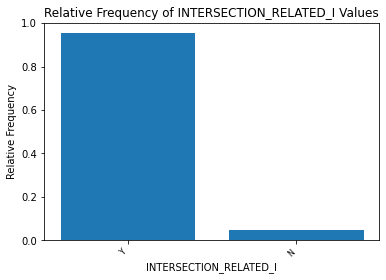

In [ ]:
plot_column_frequency(df, "INTERSECTION_RELATED_I")

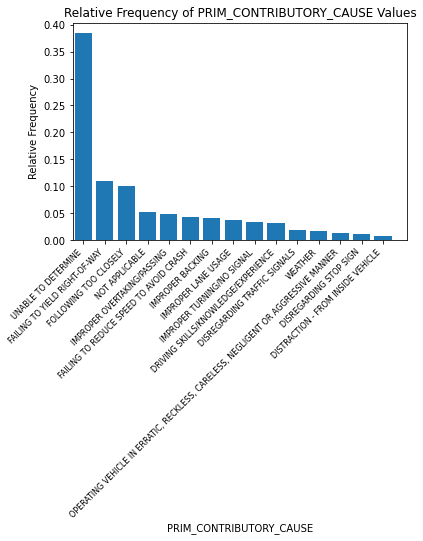

In [ ]:
plot_column_frequency(df, "PRIM_CONTRIBUTORY_CAUSE", top_n=15)

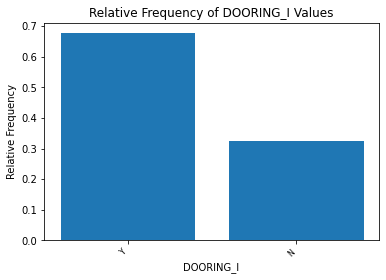

In [ ]:
plot_column_frequency(df, "DOORING_I")

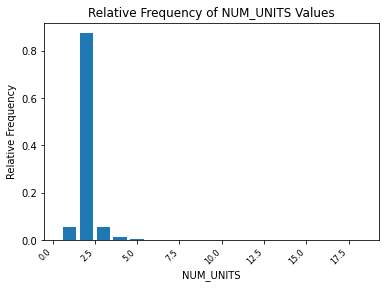

In [ ]:
plot_column_frequency(df, "NUM_UNITS")

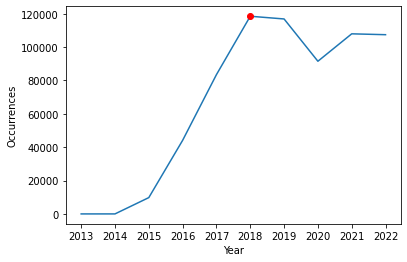

In [96]:
# Count the occurrences of each unique value in the YEAR column
year_counts = df[df['YEAR'] != 2023]['YEAR'].value_counts().sort_index()

# Create a line plot of the counts
plt.plot(year_counts.index, year_counts.values)

# Add a dot to each point on the line plot
plt.plot(year_counts.idxmax(), year_counts.max(), 'o', color='red')

# Set the x and y axis labels
plt.xlabel('Year')
plt.ylabel('Occurrences')

# Set the ticks and labels for the x axis
plt.xticks(year_counts.index)

# Display the plot
plt.show()

In [ ]:
file_path = os.path.join(GOOGLE_DRIVE_PATH, 'data/crash_data_updated.csv')
#print(file_path)
# Read in the CSV file as a pandas dataframe
df2 = pd.read_csv(file_path) 
df2.columns

Index(['year', 'month', 'weekday', 'time', 'speed_limit', 'traffic_signal',
       'device_condition', 'damage', 'police_notified', 'street_name',
       'most_severe_injury', 'latitude', 'longtitude'],
      dtype='object')

In [97]:
df.columns

Index(['CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE',
       'NUM_UNITS', 'ROADWAY_SURFACE_COND', 'ALIGNMENT', 'DEVICE_CONDITION',
       'DAMAGE', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
       'PRIM_CONTRIBUTORY_CAUSE', 'INTERSECTION_RELATED_I', 'STREET_NO',
       'STREET_NAME', 'STREET_DIRECTION', 'DOORING_I', 'TRAFFICWAY_TYPE',
       'INJURIES_TOTAL', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'YEAR', 'MONTH',
       'DAY', 'HOUR', 'MINUTE', 'SECOND', 'AM_PM', 'cluster', 'zipcode'],
      dtype='object')

In [99]:
df.head()

,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,NUM_UNITS,ROADWAY_SURFACE_COND,ALIGNMENT,DEVICE_CONDITION,DAMAGE,WEATHER_CONDITION,LIGHTING_CONDITION,...,LOCATION,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,AM_PM,cluster,zipcode
0,2019-03-25 14:43:00,30,TRAFFIC SIGNAL,2,DRY,STRAIGHT AND LEVEL,FUNCTIONING PROPERLY,"OVER $1,500",CLEAR,DAYLIGHT,...,POINT (-87.64120093714 41.884547224337),2019,3,25,14,43,0,PM,21,60696
1,2018-09-05 08:40:00,30,NO CONTROLS,2,DRY,STRAIGHT AND LEVEL,NO CONTROLS,"OVER $1,500",CLEAR,DAYLIGHT,...,POINT (-87.740659314632 41.968562453871),2018,9,5,8,40,0,AM,35,60630
2,2022-07-15 00:45:00,30,UNKNOWN,2,DRY,STRAIGHT AND LEVEL,UNKNOWN,"OVER $1,500",CLEAR,"DARKNESS, LIGHTED ROAD",...,POINT (-87.716203130599 41.886336409761),2022,7,15,0,45,0,AM,70,60644
3,2022-08-29 11:30:00,30,TRAFFIC SIGNAL,2,DRY,STRAIGHT AND LEVEL,FUNCTIONING PROPERLY,"$501 - $1,500",CLEAR,DAYLIGHT,...,POINT (-87.721096727406 41.749348170421),2022,8,29,11,30,0,AM,54,60652
4,2022-07-15 18:50:00,30,TRAFFIC SIGNAL,2,DRY,STRAIGHT AND LEVEL,FUNCTIONING PROPERLY,"OVER $1,500",CLEAR,DAYLIGHT,...,POINT (-87.667997321599 41.925110815832),2022,7,15,18,50,0,PM,19,60622
